# Comparison of KDE on Synthetic Data

## General Imports

In [1]:
# Cell for personal sys path fixes ...
import sys
sys.path=['', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/bin', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python27.zip', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-darwin', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac/lib-scriptpackages', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-tk', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-old', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload', '/Users/krell/Library/Python/2.7/lib/python/site-packages', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/aubio-0.4.5a1-py2.7-macosx-10.12-x86_64.egg', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/extensions', '/Users/krell/.ipython']
sys.path.append("/Users/krell/Documents/pyspace")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import copy
import sys
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict

from scipy.stats import norm, uniform
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde

from statsmodels.api import nonparametric
KDEMultivariate = nonparametric.KDEMultivariate
default_KDE = nonparametric.EstimatorSettings(efficient=True)

print "Package Versions:"
import sklearn; print "  scikit-learn:", sklearn.__version__
import scipy; print "  scipy:", scipy.__version__
import statsmodels; print "  statsmodels:", statsmodels.__version__
import numpy; print "  scipy:", numpy.__version__
import matplotlib; print "  matplotlib:", matplotlib.__version__

Package Versions:
  scikit-learn: 0.18.1
  scipy: 0.19.0
  statsmodels: 0.8.0
  scipy: 1.12.1
  matplotlib: 2.0.0


## Utility functions

In [3]:
def run_single_analysis_plot(data, true_density, x_grid):
    """Compare different bandwidth estimators to match data on true_density
    
    true_density is sampled at the x_grid, which is also used for plotting.
    Additionally, optimization time of the estimators and r2 score 
    are reported.
    """
    plt.figure(figsize=(8,5))
    data = copy.deepcopy(data)
    np.random.seed(1)
    np.random.shuffle(data)
    # approaches from statsmodels
    # Optionally, "normal_reference" could be used, too.
    for method in ["cv_ml", "cv_ls"]:
        for efficient in [True, False]:
            default_KDE = nonparametric.EstimatorSettings(
                efficient=efficient)
            t = time.time()
            kde = KDEMultivariate(
                data=[data], var_type='c', bw=method, 
                defaults=default_KDE)
            # uses x_grid and true_density for testing
            density_estimate = kde.pdf(x_grid)
            tf = time.time()
            print '%s score:'%method, r2_score(
                true_density, density_estimate),\
                ' time:', tf-t, ' efficient:', str(efficient)
            plt.plot(x_grid, density_estimate, 
                     label=method+"_"+str(efficient))
    # approaches from scipy.stats
    for method in ["scott", "silverman"]:
        t = time.time()
        kde = gaussian_kde(data, method)
        # uses x_grid and true_density for testing
        density_estimate = kde(x_grid.flatten())
        tf = time.time()
        print '%s score:'%method, r2_score(
            true_density, density_estimate), ' time:', tf-t
        plt.plot(x_grid, density_estimate,label=method)
    plt.plot(x_grid, true_density, '--k', label ='true density')
    plt.legend(loc='best')
    
def sample_eval_kde(data, true_density, x_grid, n_samples):
    """Divide n_samples into 10 chunks to generate KDE performance curves
    
    The curves are not plotted but returned as dictionaries of lists
    with the estimation methods that shall be evaluated as keys.
    *data is used to fit the KDE and true_density for evaluating it 
    on x_grid.
    
    Code is very similar to :func:`run_single_analysis_plot`
    """
    density_scores = defaultdict(list)
    density_times = defaultdict(list)
    data = copy.deepcopy(data)
    np.random.seed(1)
    np.random.shuffle(data)
    for i in range(int(n_samples/10),n_samples+1,int(n_samples/10)):
        # Counter output to know at which stage the processing
        # is currently at.
        sys.stdout.write("\r%d" % i)
        sys.stdout.flush()
        for method in ["cv_ml", "cv_ls"]:
            for efficient in [True, False]:
                default_KDE = nonparametric.EstimatorSettings(
                    efficient=efficient)
                t = time.time()
                kde = KDEMultivariate(
                    data=[data[:i]], var_type='c', bw=method, 
                    defaults=default_KDE)
                density_estimate = kde.pdf(x_grid)
                tf = time.time()
                density_scores[method+"_"+str(efficient)].append(
                    r2_score(true_density, density_estimate))
                density_times[method+"_"+str(efficient)].append(tf-t)
        for method in ["scott", "silverman"]:
            t = time.time()
            kde = gaussian_kde(data[:i], method)
            density_estimate = kde(x_grid.flatten())
            tf = time.time()
            density_scores[method].append(
                r2_score(true_density, density_estimate))
            density_times[method].append(tf-t)
    return density_scores, density_times

def print_n_density_scores(density_scores, density_times, n_samples):
    """Plot results from :func:`sample_eval_kde`"""
    plt.figure()
    for method in [ "cv_ml", "cv_ls"]:
        for efficient in [True, False]:
            plt.plot(
                range(int(n_samples/10), n_samples+1, int(n_samples/10)),
                density_scores[method+"_"+str(efficient)], '-v',
                label=method+"_"+str(efficient))
    for method in ["scott", "silverman"]:
        plt.plot(range(int(n_samples/10), n_samples+1, int(n_samples/10)),
                 density_scores[method],'-v', label=method)
    plt.legend(loc='best')
    plt.xlabel('samples')
    plt.ylabel('scores')

    plt.figure()
    for method in [ "cv_ml", "cv_ls"]:
        for efficient in [True, False]:
            plt.plot(range(int(n_samples/10),n_samples+1,int(n_samples/10)),
                     density_times[method+"_"+str(efficient)],'-v',
                     label=method+"_"+str(efficient))
    for method in ["scott", "silverman"]:
        plt.plot(range(int(n_samples/10),n_samples+1,int(n_samples/10)),
                 density_times[method],'-v', label=method)
    plt.legend(loc='best')
    plt.xlabel('samples')
    plt.ylabel('time (s)')

## 6 Different sums of Gaussians: Plot and Generation

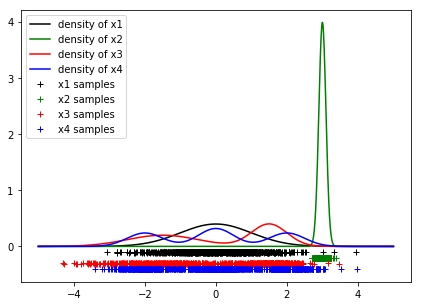

In [4]:
# Generate data
n_samples = 1000
# 1k samples
np.random.seed(1)
x1 = np.random.normal(0, 1, n_samples)
np.random.seed(1)
x2 = np.random.normal(3, 0.1, n_samples)
np.random.seed(1)
x3 = np.concatenate((np.random.normal(-1.5, 1, int(0.5*n_samples)), 
                     np.random.normal(1.5, 0.5, int(0.5*n_samples))))
np.random.seed(1)
x4 = np.concatenate((np.random.normal(-2, 0.5, int(0.3*n_samples)), 
                     np.random.normal(2, 0.5, int(0.3*n_samples)),
                     np.random.normal(0, 0.5, int(0.4*n_samples))))
# 10k samples
np.random.seed(1)
x3_10k = np.concatenate((np.random.normal(-1.5, 1, int(5*n_samples)), 
                         np.random.normal(1.5, 0.5, int(5*n_samples))))
np.random.seed(1)
x4_10k = np.concatenate((np.random.normal(-2, 0.5, int(3*n_samples)), 
                         np.random.normal(2, 0.5, int(3*n_samples)),
                         np.random.normal(0, 0.5, int(4*n_samples))))

# Generate respective true values/functions
X_plot = np.linspace(-5, 5, 1001)[:, np.newaxis]

true_dens_x1 =  norm(0, 1).pdf(X_plot[:, 0])
             
true_dens_x2 =  norm(3, 0.1).pdf(X_plot[:, 0])
             
true_dens_x3 = (0.5 * norm(-1.5, 1).pdf(X_plot[:, 0]) + \
                0.5 * norm(1.5, 0.5).pdf(X_plot[:, 0]))

true_dens_x4 = (0.3 * norm(-2, 0.5).pdf(X_plot[:, 0]) + \
                0.3 * norm(2, 0.5).pdf(X_plot[:, 0]) + \
                0.4 * norm(0, 0.5).pdf(X_plot[:, 0]))
# plot true densities and scattered data
plt.figure(figsize=(7,5))
plt.plot(X_plot, true_dens_x1, 'k', label='density of x1')
plt.plot(X_plot, true_dens_x2, 'g', label='density of x2')
plt.plot(X_plot, true_dens_x3, 'r', label='density of x3')
plt.plot(X_plot, true_dens_x4, 'b' , label='density of x4')
plt.plot(x1, -0.1 - 0.01 * np.random.random(x1.shape[0]), '+k', 
         label='x1 samples')
plt.plot(x2, -0.2 - 0.01 * np.random.random(x2.shape[0]), '+g', 
         label='x2 samples')
plt.plot(x3, -0.3 - 0.01 * np.random.random(x3.shape[0]), '+r', 
         label='x3 samples')
plt.plot(x4, -0.4 - 0.01 * np.random.random(x4.shape[0]), '+b', 
         label='x4 samples')
plt.legend(loc=2)

## Simple Gaussians

- Print performance values on full data for x1 and x2 which are single Gaussians
- Plot distribution and estimates on full data for the different fits
- Evaluate for different numbers of samples
- Plot results

case x1
cv_ml score: 0.99588134054  time: 0.801782846451  efficient: True
cv_ml score: 0.99587936429  time: 1.02907419205  efficient: False
cv_ls score: 0.995858842339  time: 0.899650096893  efficient: True
cv_ls score: 0.99565489781  time: 1.05867600441  efficient: False
scott score: 0.995039218105  time: 0.0315048694611
silverman score: 0.99533588977  time: 0.0246040821075
1000

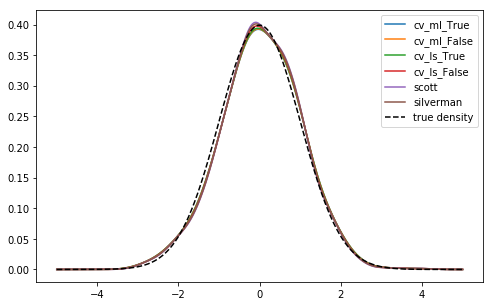

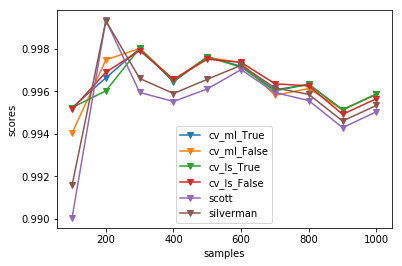

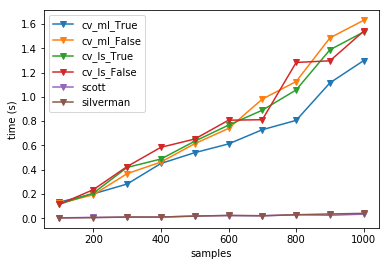

In [5]:
print ("case x1")
run_single_analysis_plot(x1, true_dens_x1, X_plot)
density_scores, density_times = sample_eval_kde(
    x1, true_dens_x1, X_plot, n_samples)
print_n_density_scores(density_scores, density_times, n_samples)

case x2
cv_ml score: 0.997242320273  time: 1.01061201096  efficient: True
cv_ml score: 0.997240921644  time: 1.44292902946  efficient: False
cv_ls score: 0.997228243093  time: 0.996782064438  efficient: True
cv_ls score: 0.997077450872  time: 0.751837015152  efficient: False
scott score: 0.996678380009  time: 0.0319521427155
silverman score: 0.996877024205  time: 0.0340309143066
1000

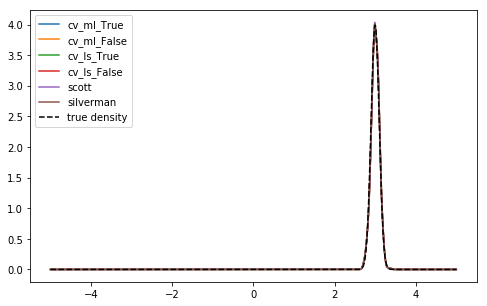

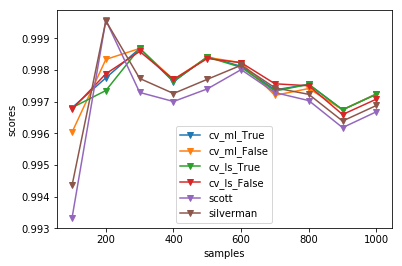

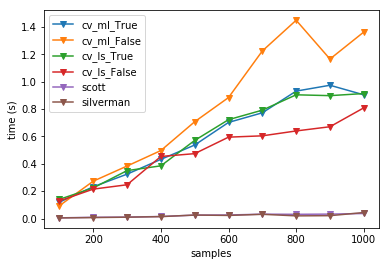

In [6]:
print ("case x2")
run_single_analysis_plot(x2, true_dens_x2, X_plot)
density_scores, density_times = sample_eval_kde(
    x2, true_dens_x2, X_plot, n_samples)
print_n_density_scores(density_scores, density_times, n_samples)

## Sum of Gaussians

- Print performance values on full data for x3 and x4 which are the sum of two or three Gaussians
- Plot distribution and estimates on full data for the different fits
- Evaluate for different numbers of samples
- Plot results

case x3
cv_ml score: 0.991906649234  time: 1.65259790421  efficient: True
cv_ml score: 0.991850330573  time: 2.19696903229  efficient: False
cv_ls score: 0.991747539877  time: 1.73318910599  efficient: True
cv_ls score: 0.992005833574  time: 2.47120714188  efficient: False
scott score: 0.948369444317  time: 0.0337069034576
silverman score: 0.938086218005  time: 0.0339319705963
1000

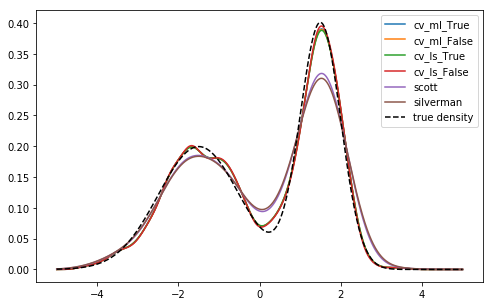

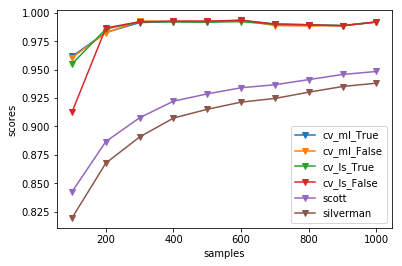

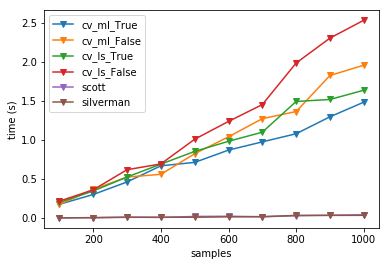

In [7]:
print ("case x3")
run_single_analysis_plot(x3, true_dens_x3, X_plot)
density_scores, density_times = sample_eval_kde(
    x3, true_dens_x3, X_plot, n_samples)
print_n_density_scores(density_scores, density_times, n_samples)

case x4
cv_ml score: 0.988285833907  time: 1.50160384178  efficient: True
cv_ml score: 0.988264955211  time: 2.39952206612  efficient: False
cv_ls score: 0.988285833907  time: 1.86064910889  efficient: True
cv_ls score: 0.98769059415  time: 2.96119499207  efficient: False
scott score: 0.921000608117  time: 0.0474319458008
silverman score: 0.906631789511  time: 0.0440340042114
1000

KeyboardInterrupt: 

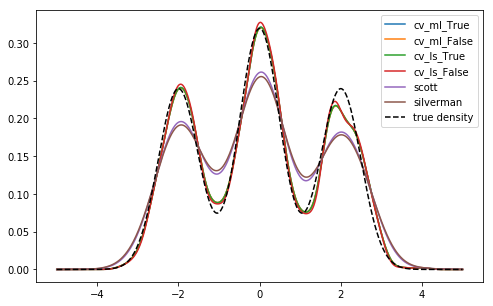

In [8]:
print ("case x4")
run_single_analysis_plot(x4, true_dens_x4, X_plot)
density_scores, density_times = sample_eval_kde(
    x4, true_dens_x4, X_plot, n_samples)
print_n_density_scores(density_scores, density_times, n_samples)

## 10k Examples

Same procedure as before for the sum of Gaussians (x3, x4) but with 10k instead of 1k samples.

In [ ]:
print ("case x3 w/ 10k samples")
run_single_analysis_plot(x3_10k, true_dens_x3, X_plot)
density_scores, density_times = sample_eval_kde(
    x3_10k, true_dens_x3, X_plot, 10*n_samples)
print_n_density_scores(density_scores, density_times, 10*n_samples)

In [ ]:
print ("case x4 w/ 10k samples")
run_single_analysis_plot(x4_10k, true_dens_x4, X_plot)
density_scores, density_times = sample_eval_kde(
    x4_10k, true_dens_x4, X_plot, 10*n_samples)
print_n_density_scores(density_scores, density_times, 10*n_samples)

## Sum of Uniform and Gaussian

Generate, visualize, and evaluate the distribution.

In [ ]:
sd = 1
mean = 0


x = np.concatenate((np.random.normal(mean, sd, int(0.5 * n_samples)), 
                    np.random.uniform(-4, 4, int(0.5 * n_samples))))

true_dens_x = (0.5 * uniform.pdf(X_plot,loc=-4,scale=8).flatten() + \
               0.5 * norm(mean, sd).pdf(X_plot[:, 0]))

plt.figure(figsize=(7,5))
plt.plot(X_plot, true_dens_x, label='density of x')
plt.plot(x, -0.02 - 0.01 * np.random.random(x.shape[0]), '+k', 
         label='x samples')

In [ ]:
print ("Uniform mixed with normal")
sd = 1 
mean = 0 

x = np.concatenate((np.random.normal(mean, sd, int(0.5 * n_samples)), 
                    np.random.uniform(-4, 4, int(0.5 * n_samples))))

true_dens_x = (0.5 * uniform.pdf(X_plot,loc=-4,scale=8).flatten() + \
               0.5 * norm(mean, sd).pdf(X_plot[:, 0]))
run_single_analysis_plot(x, true_dens_x, X_plot)
density_scores, density_times = sample_eval_kde(
    x, true_dens_x, X_plot, n_samples)
print_n_density_scores(density_scores, density_times, n_samples)

## Laplace Distribution

Generate, visualize, and evaluate the distribution.

In [ ]:
loc, scale = 0., 1.5
x = np.random.laplace(loc, scale, n_samples)

true_dens_x = np.exp(-abs(X_plot - loc) / scale) / (2. * scale)

plt.plot(X_plot,true_dens_x)
plt.plot(x, -0.02-0.01*np.random.random(x.shape[0]), '+k', 
         label='x samples')

In [ ]:
print ("Laplace Distribution")
run_single_analysis_plot(x, true_dens_x, X_plot)
density_scores, density_times = sample_eval_kde(
    x, true_dens_x, X_plot, n_samples)
print_n_density_scores(density_scores, density_times, n_samples)

## Chi Square

Generate, visualize, and evaluate the Chi Square distribution with three degrees of freedom.

In [ ]:
from scipy.stats import chi2
df = 3
n_samples=1000
x = np.random.chisquare(df,n_samples)-5
true_dens_x = chi2.pdf(X_plot+5,df)
plt.plot(X_plot,true_dens_x)
plt.plot(x, -0.02 - 0.01 * np.random.random(x.shape[0]), '+k', 
         label='x samples')

In [ ]:
print("Chi Square DF3")
run_single_analysis_plot(x, true_dens_x, X_plot)
density_scores, density_times = sample_eval_kde(
    x, true_dens_x, X_plot, n_samples)
print_n_density_scores(density_scores, density_times, n_samples)

# Visualization of KDE on Robotic Data

## Load and Visualize Data

The data ordering is different to the paper. Dataset 1 and 2 are exchanged. Furthermore, we took only the region between sample 4000 and 5000 for the visualization of dataset 3.

In [9]:
data1 = np.loadtxt('data_r.csv', delimiter=',')
data2 = np.loadtxt('data_1_test_10Hz.csv', delimiter=',')
data3 = np.loadtxt('data_r_combined.csv', delimiter=',')

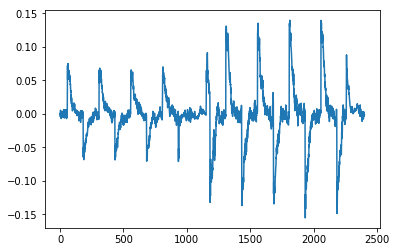

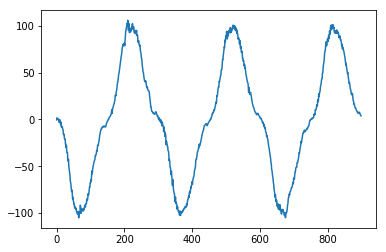

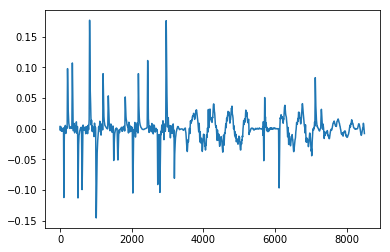

In [10]:
features1, targets1 = data1[:,0:2], data1[:,2]
features2, targets2 = data2[:,0:1], data2[:,1]
features3, targets3 = data3[:,0:2], data3[:,2]

plt.figure()
plt.plot(targets1)
plt.figure()
plt.plot(targets2)
plt.figure()
plt.plot(targets3)

## Plotfunction from robotic_data Notebook

In [11]:
def plot_hist_and_KDE(data, x_grid, xlabel=None):
    """Plot the histogram of the *data* and the respective KDE
    
    The statsmodels KDE is used.
    *x_grid* defines the point used for plotting the function.
    If *xlabel* is provided, it is used as label for the x-axis.
    """
    # larger tick labels needed for plotting in paper
    label_size = 22
    plt.rcParams['xtick.labelsize'] = label_size 
    plt.rcParams['ytick.labelsize'] = label_size 
    fig = plt.figure()
     # "normal_reference" could be used for speed up instead or "cv_ml"
    method = "cv_ls"
    efficient = True
    default_KDE = nonparametric.EstimatorSettings(efficient=efficient)
    t = time.time()
    # Core KDE fitting
    kde = KDEMultivariate(data=[data], var_type='c', 
                          bw=method, defaults=default_KDE)
    density_estimate = kde.pdf(x_grid)
    tf = time.time()
    plt.plot(x_grid, density_estimate, linewidth=3, color="k")
    plt.legend(loc='best')
    # rwidth is required to see the bars.
    plt.hist(data, bins=50, normed=1, histtype="bar", rwidth=0.5)
    if not xlabel is None:
        plt.xlabel(xlabel, fontsize=label_size)
    #plt.ylabel("density", fontsize=label_size+2)

## Dataset 1

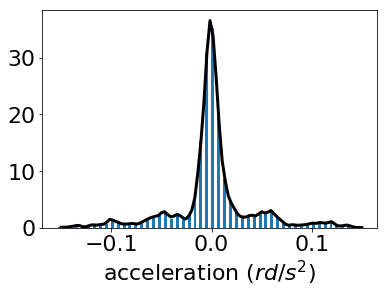

In [12]:
X_plot = np.linspace(-0.15,0.15,100)
plot_hist_and_KDE(targets1, X_plot, "acceleration ($rd/s^2$)")

## Dataset 2 (also used for metric evaluation as dataset 1 in paper)

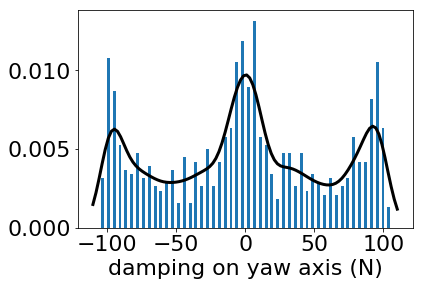

In [13]:
X_plot = np.linspace(-110,110,100)
plot_hist_and_KDE(targets2, X_plot,"damping on yaw axis (N)")

## Dataset 3 (also used for evaluation in paper)

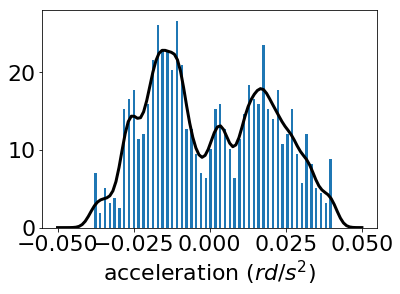

In [14]:
X_plot = np.linspace(-0.05,0.05,100)
plot_hist_and_KDE(targets3[4000:5000], X_plot, "acceleration ($rd/s^2$)")

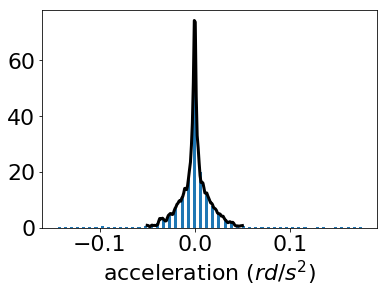

In [15]:
X_plot = np.linspace(-0.05,0.05,100)
plot_hist_and_KDE(targets3, X_plot, "acceleration ($rd/s^2$)")